# Check how to limit the maximum depth

# Method 2: using grad from a ReLU network between depth and target

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import sys
sys.path.append("/home/wukailu/latent-nerf/src/ControlNet")
import torch
from torch import nn
from ldm.modules.diffusionmodules.openaimodel import UNetModel

device = torch.device("cpu")
mean_std = torch.tensor([
    (-0.24595006, 0.54566), # R
    (-0.13202806, 0.55846), # G
    (-0.02775778, 0.57430), # B
    ( 1.72314970, 0.99023), # D
])
mean, std = mean_std.to(device=device).unbind(dim=1)

In [2]:
IMG_SIZE = 128
def get_unet():
    unet = UNetModel(image_size=IMG_SIZE,
                     in_channels=8, out_channels=4,
                     model_channels=128, # the base channel (smallest)
                     channel_mult=[1, 2, 3, 3, 4, 4],
                     num_res_blocks=2,
                     num_head_channels=32,
                     # down 1     2      4          8          16         32
                     # res  128   64     32         16         8          4
                     # chan 128   256    384        384        512        512
                     # type conv  conv   conv+attn  conv+attn  conv+attn  conv+attn
                     attention_resolutions=[4, 8, 16, 32],
                     use_checkpoint=True,
                     use_fp16=False,
                    )
    # use num_groups==1, to avoid color shift problem
    for name, module in unet.named_modules():
        if isinstance(module, nn.GroupNorm):
            module.num_groups = 1
            print(f"convert GN to LN for module: {name}")
    return unet

class Model(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.unet = get_unet()
        # dummy params
        self.no_pixel = nn.Parameter(torch.zeros(4))

    def forward(self, rgbd, t):
        """
        Args:
            rgbd.shape == (B, 4, H, W)

            NOTE
            curr view (i.e. rgbd) is noised
        """
        rgbd_render = torch.zeros_like(rgbd)
        unet_in = torch.cat([rgbd_render, rgbd], dim=1) # (B, 4 + 4, H, W)
        pred = self.unet(unet_in, t) # (B, C, H, W)
        return pred

In [4]:
# load model from dir_ckpt, "checkpoint", "model.pt"
model_path = "/home/wukailu/RGBD-Diffusion/out/RGBD2/checkpoint/model.pt"
ckpt = torch.load(model_path)
model = Model()
model.load_state_dict(ckpt['model'])

convert GN to LN for module: input_blocks.1.0.in_layers.0
convert GN to LN for module: input_blocks.1.0.out_layers.0
convert GN to LN for module: input_blocks.2.0.in_layers.0
convert GN to LN for module: input_blocks.2.0.out_layers.0
convert GN to LN for module: input_blocks.4.0.in_layers.0
convert GN to LN for module: input_blocks.4.0.out_layers.0
convert GN to LN for module: input_blocks.5.0.in_layers.0
convert GN to LN for module: input_blocks.5.0.out_layers.0
convert GN to LN for module: input_blocks.7.0.in_layers.0
convert GN to LN for module: input_blocks.7.0.out_layers.0
convert GN to LN for module: input_blocks.7.1.norm
convert GN to LN for module: input_blocks.8.0.in_layers.0
convert GN to LN for module: input_blocks.8.0.out_layers.0
convert GN to LN for module: input_blocks.8.1.norm
convert GN to LN for module: input_blocks.10.0.in_layers.0
convert GN to LN for module: input_blocks.10.0.out_layers.0
convert GN to LN for module: input_blocks.10.1.norm
convert GN to LN for modu

<All keys matched successfully>

In [27]:
from einops import rearrange
from diffusers import DDIMScheduler
from tqdm import tqdm

num_steps  = 50
diffusion_scheduler = DDIMScheduler(num_train_timesteps=1000, clip_sample=False, set_alpha_to_one=False)
@torch.no_grad()
def sampling_forward_fn(rgbd, t): # forward func only for classifier-free sampling
    t = t.reshape([1])
    # forward
    with torch.cuda.amp.autocast(enabled=True):
        pred = model.unet(rgbd, t)
    return pred.float()

class Sampler:
    @torch.no_grad()
    def __call__(self, seed, call_back=None):
        # sample noise
        kwargs_rand = lambda seed, device=device: dict(generator=torch.Generator(device).manual_seed(seed), device=device)
        z_t = torch.randn([1, 4, IMG_SIZE, IMG_SIZE], **kwargs_rand(seed))
        # compute the known part by rendering the mesh onto the current view
        known_part = torch.zeros((1, 4, IMG_SIZE, IMG_SIZE), device=device)
        #
        diffusion_scheduler.set_timesteps(num_steps)
        #
        time_step_lst = diffusion_scheduler.timesteps
        assert num_steps == diffusion_scheduler.num_inference_steps == len(time_step_lst)
        #
        model.eval()
        for i, t in tqdm(enumerate(time_step_lst)):
            rgbd_in = torch.cat([known_part, z_t], dim=1)  # (1, 8, H, W)
            pred_noise = sampling_forward_fn(rgbd_in, t.to(device=device))
            if call_back is not None:
                call_back(i, t, pred_noise, z_t)
            z_t = diffusion_scheduler.step(pred_noise, t.to(device=device), z_t).prev_sample
        # reshape to (H, W, C)
        rgbd_curr = rearrange(z_t, "() C H W -> H W C")
        rgbd_curr = rgbd_curr * std + mean
        rgbd_curr[..., :3] = (rgbd_curr[..., :3] + 1) / 2 # 0~1
        rgbd_curr[..., :3] = rgbd_curr[..., :3].clamp(min=0, max=1)
        rgbd_curr[...,  3] = rgbd_curr[...,  3].clamp(min=0)
        return rgbd_curr

def visual_depth_callback(ref):
    import numpy as np
    def callback(i, t, noise_pred_uncond, model_input, ref_rgbd=ref):
        with torch.no_grad():
            d_max = ref_rgbd[..., 3:].max()
            threshold = d_max * 0.05
            ref = ref_rgbd[..., 3].clone()
            d_min = ref[ref >= threshold].min()
            d_max = ref[ref >= threshold].max()
            print("range", d_min, d_max)
            def visual_depth(rgbd_input):
                dps = rgbd_input[0, -1].cpu().detach()  # [512,512]
                dps = dps * std[3] + mean[3]
                dps = ((dps - d_min) / (d_max - d_min) * 255.).clip(0, 255).round().numpy().astype(np.uint8)
                return Image.fromarray(dps)
            print("model_input shape", model_input.shape)
            display(visual_depth(model_input))
    return callback


def midas_callback_rgbd(i, t, noise_pred_uncond, model_input):
    # TODO: check this
    with torch.cuda.amp.autocast(enabled=True):
        with torch.enable_grad():
            ltt: torch.Tensor = model_input.detach()
            ltt = ltt.requires_grad_(True)

            pred = ltt[:, -1]
            target = torch.ones_like(pred) * (pred.mean().detach())
            loss_func = torch.nn.MSELoss()  # MSE because we assume it follows a normal distribution
            loss = loss_func(pred.flatten(start_dim=1), target.flatten(start_dim=1))
            loss.backward()

        grad = ltt.grad * -0.5 * 3 / (1**2)  # divide sigma^2, if depth distribution follows N(target, sigma)
        grad = grad.to(dtype=noise_pred_uncond.dtype)
        sqrt_one_minus_alpha_prod = (1 - diffusion_scheduler.alphas_cumprod[t]) ** 0.5
        noise_pred_uncond -= sqrt_one_minus_alpha_prod.to(grad) * grad
        print("grad", grad.mean(), grad.std(), grad.shape)
        print("noise_pred_uncond", noise_pred_uncond.mean(), noise_pred_uncond.std(), noise_pred_uncond.shape)

In [20]:
run = Sampler()
rgbd = run(seed=237) # (H, W, 4)

50it [00:26,  1.86it/s]


In [21]:
from PIL import Image
import numpy as np

def show_rgbd(rgbd_display):
    rgbd_input = rgbd_display.clone()
    rgbd_input[..., :3] = rgbd_input[..., :3] * 255
    d_max = rgbd_input[..., 3:].max()
    threshold = d_max * 0.05
    ref = rgbd_input[..., 3].clone()
    d_min = ref[ref >= threshold].min()
    d_max = ref[ref >= threshold].max()
    ref = (ref - d_min).clip(0) / (d_max - d_min) * 255
    rgbd_input[..., 3] = ref

    pil = Image.fromarray(rgbd_input.numpy().round().astype(np.uint8)[..., :3])
    display(pil)
    pil = Image.fromarray(rgbd_input.numpy().round().astype(np.uint8)[..., 3])
    display(pil)
    pil = Image.fromarray(rgbd_input.numpy().round().astype(np.uint8))
    display(pil)

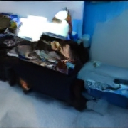

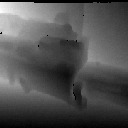

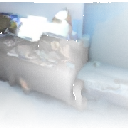

(tensor(2.9389), tensor(2.0510))

In [23]:
show_rgbd(rgbd)
rgbd[..., 3].max(), rgbd[..., 3].mean()

0it [00:00, ?it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


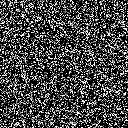

1it [00:00,  1.74it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


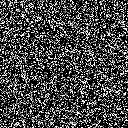

2it [00:01,  1.91it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


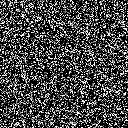

3it [00:01,  2.03it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


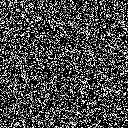

4it [00:01,  2.06it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


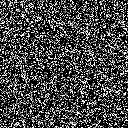

5it [00:02,  2.09it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


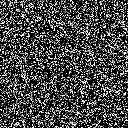

6it [00:02,  2.11it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


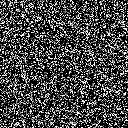

7it [00:03,  2.08it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


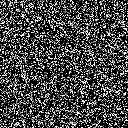

8it [00:03,  2.08it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


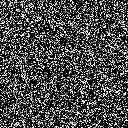

9it [00:04,  2.10it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


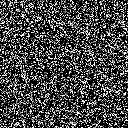

10it [00:04,  2.14it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


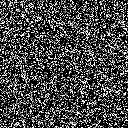

11it [00:05,  2.14it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


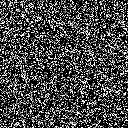

12it [00:05,  2.14it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


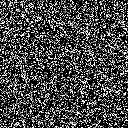

13it [00:06,  2.18it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


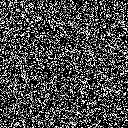

14it [00:06,  2.17it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


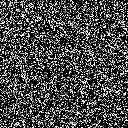

15it [00:07,  2.15it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


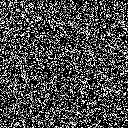

16it [00:07,  2.10it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


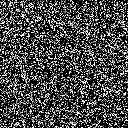

17it [00:08,  2.02it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


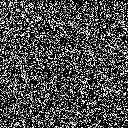

18it [00:08,  2.07it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


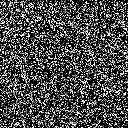

19it [00:09,  2.10it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


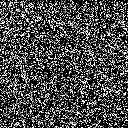

20it [00:09,  2.13it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


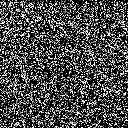

21it [00:10,  2.13it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


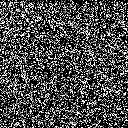

22it [00:10,  2.16it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


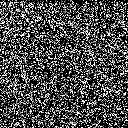

23it [00:10,  2.17it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


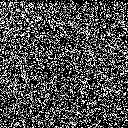

24it [00:11,  2.17it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


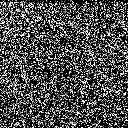

25it [00:11,  2.16it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


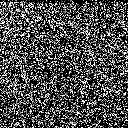

26it [00:12,  2.16it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


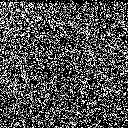

27it [00:12,  2.14it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


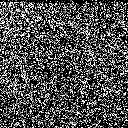

28it [00:13,  2.16it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


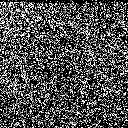

29it [00:13,  2.11it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


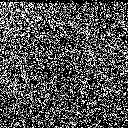

30it [00:14,  2.06it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


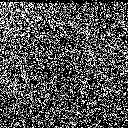

31it [00:14,  2.05it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


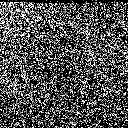

32it [00:15,  2.03it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


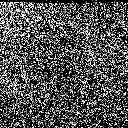

33it [00:15,  1.93it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


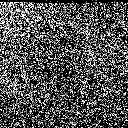

34it [00:16,  1.97it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


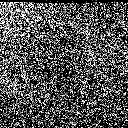

35it [00:16,  2.01it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


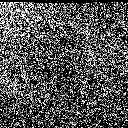

36it [00:17,  2.03it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


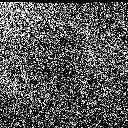

37it [00:17,  2.09it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


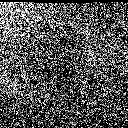

38it [00:18,  2.12it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


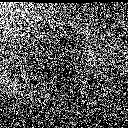

39it [00:18,  2.14it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


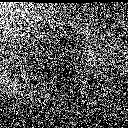

40it [00:19,  2.16it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


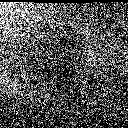

41it [00:19,  2.18it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


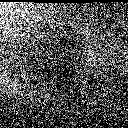

42it [00:19,  2.22it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


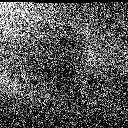

43it [00:20,  2.21it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


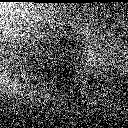

44it [00:20,  2.21it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


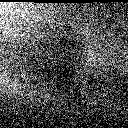

45it [00:21,  2.23it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


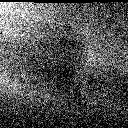

46it [00:21,  2.22it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


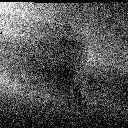

47it [00:22,  2.22it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


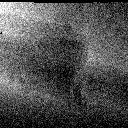

48it [00:22,  2.24it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


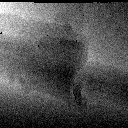

49it [00:23,  2.25it/s]

range tensor(1.6895) tensor(2.9389)
model_input shape torch.Size([1, 4, 128, 128])


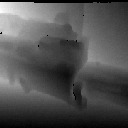

50it [00:23,  2.12it/s]


In [28]:
_ = run(seed=237, call_back=visual_depth_callback(rgbd)) # (H, W, 4)

In [29]:
def generate_depth_limit(rgbd):
    depths = rgbd[..., 3]
    threshold = depths.max() * 0.05
    d_mean = depths[depths > threshold].mean()
    return np.ones_like(depths) * d_mean

In [ ]:
def visual_limit(limit):
    if isinstance(limit, torch.Tensor):
        dps = limit.cpu().numpy()[0]  # [512,512]
    else:
        dps = limit
    d_min = dps.min()
    d_max = dps.max()
    dps = ((dps - d_min) / (d_max - d_min) * 255.).round().astype(np.uint8)
    return Image.fromarray(dps)

In [31]:
d_limits = generate_depth_limit(rgbd.numpy())

In [ ]:
def midas_limit_depth(depth_limit):
    def callback(i, t, noise_pred_uncond, model_input, target=depth_limit):
        # TODO: check this
        with torch.cuda.amp.autocast(enabled=True):
            with torch.enable_grad():
                ltt: torch.Tensor = model_input.detach()
                ltt = ltt.requires_grad_(True)

                pred = ltt[:, -1]
                mask = (pred > target)
                loss_func = torch.nn.MSELoss()  # MSE because we assume it follows a normal distribution
                loss = loss_func(pred[mask], target[mask])
                loss.backward()

            grad = ltt.grad * -0.5 * 3 / (1**2)  # divide sigma^2, if depth distribution follows N(target, sigma)
            grad = grad.to(dtype=noise_pred_uncond.dtype)
            sqrt_one_minus_alpha_prod = (1 - diffusion_scheduler.alphas_cumprod[t]) ** 0.5
            noise_pred_uncond -= sqrt_one_minus_alpha_prod.to(grad) * grad
            print("grad", grad.mean(), grad.std(), grad.shape)
            print("noise_pred_uncond", noise_pred_uncond.mean(), noise_pred_uncond.std(), noise_pred_uncond.shape)
    return callback

# Method 3: extend method 2 to latent diffusion